# Summary of my work

## Introduction
 - I have read several papers on electricity price forecasting before.
 - Mostly related to forecasting day-ahead market prices.
 - Several takeaways for this task:
    1) Prices are usually mean stationary, so there is no need to take (partial) differences.
    2) Prices are right-skewed with occasional spikes - similar to the volatility forecasting tasks.
    3) Transformations (e.g. logarithmic) may be useful, but it depends on what the model is for (practical use).
  
## Data exploration
 -  Observations from data exploration:
    1) Target variables show frequent spikes and positive skewness
        - Possible treatments, but only if our goal is to have the most accurate model (out-of-sample unbiasedness, which may not be the most profit maximizing approach):
             1) Transform the data (winsorization, log, box-cox).
             2) Weighted least square (weight is inverse of price).
             3) Training model under asymmetric loss functions (e.g., QLIKE, LIN-LIN).
    2) Strong seasonalities
        - We can decompose seasonalities of different lengths (within a day, week and year).
    3) Missing data at the beginning of the sample
    4) None of the data (considering the whole sample) shows non-stationarity.
        - Using ADF and KPSS, there was no unit root indicated in the target variable (also by simple graphical inspection, it appears to be at least weakly stationary) -- however, as some papers indicate, the variance increases over time with the higher share of renewables in the energy mix, so in a longer sample there is likely to be no weak stationarity (based on this observation, the question is how severe these changes in variance are).
    6) Additional features created are strongly linearly correlated
        - In general, I do not like the approach of reducing the dimensions (e.g. by PCA) or dropping the highly correlated features (e.g. LASSO will do this).
        - As there are strong dependencies in the quantiles but not in the means (there are hundreds of papers on this with cross-quantilograms etc.) -> intuitively, we may be missing important information in the quantiles.
        - Also being careful when interpreting the significance of each variable as:
            - Even when using model agnostic interpretation methods such as permutation feature significance -- are highly biased in the presence of multicollinearity issue.
    7) Two ways to approach the modelling task
        - All in one (modelling with multi-output regression to get 168 predictions)
        - Hours separately or some time-in-a-day clusters together
          - The reason for the 2 working better is that the DGP at 00:00 might be very different from the DGP at 12:00.
          - It is also done this way in the day-ahead auction market predictions.
          - Advantageously, this simplifies the extraction of daily seasonality.
    8) A graphical inspection shows that some variables are outliers
        - Winsorising them did not generally improve the model fits.
    9) Implemented features
        - Past observations of prices, temperature and load
        - Their rolling means
        - Past "hour of day" observations corresponding to the predicted hour
        - US holiday dummies
        - Day-of-week dummies
        - Predictions of temperature and load
        - Surprise size of predicted vs realised temperature and load
        - Rate of change of price, temperature and load
        - Seasonal decomposition of temperature and load
  

## Model fitting and its learnability
 -  Several views, also reflected in the feature creation, on the model selection approach
    1) Past observations of price, temperature are among the most important
    2) Past hourly prices follow in importance
    3) Choosing to model only prices for a particular hour of day separately improves the fit - higher $R^2$, more normal residuals, almost no autocorrelation in the residuals as well as heteroskedasticity.
    4) Training LGBM suggests a more complex model, but simple linear cross-validated lasso performs better in out-of-sample evaluation.
 - Other considerations::
    1) Rolling/expanding window estimation.
    2) Investigate the importance of data transformation on out-of-sample (test set) performance. However..
    3) Sanity checking of predictions.
    4) Cross-validation of LGBM parameters before final training.
    5) The model was trained under **mean absolute and mean squared errors**.
        - In my view, the objective could be some directional trading, so minimising the MAE seems reasonable. However, due to the characteristics of the price time series (spikiness), it might be advantageous to train the models under an asymmetric loss function (it might pay to overestimate the price a bit due to the spikes and be on the safe side when such a spike occurs).
        - For example, this is desirable in volatility forecasting (e.g. if someone uses options, if he overestimates the volatility, he will over-insure his portfolio (lose a little on over-insurance), in the opposite case he would face much higher losses), but the Sklearn package does not allow for quick inclusion of custom losses.
        - Quantile modelling is now very popular in the financial literature. So modelling the whole distribution of possible future price realisations could be very interesting. But I did not have time for that.
    6) Evaluating the results
        - Following the above points, I use **MAE, MSE**. It might also be useful to add the asymmetric **QLIKE**, which penalises our models more for under-prediction.
        - For multiple comparisons of competing models, this could be **Model confidence set**. However, we only have two models, so the Diebold-Mariano test or the Conditional predictive ability test is sufficient.

## Implementation
 - Instructions for running the algorithm are available on github.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.ar_model import AutoReg
import missingno as msno

from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import power_transform

%load_ext autoreload
%autoreload 2
from model_pipeline import DataProcessor
import utils
import lightgbm as lgb

from pdb import set_trace

def all_data_in_one_sample(target_shift=-1):
    """
    Returns features and data that are computed over all hourly data
    as the time goes. No split is applied
    """
    data_processor = DataProcessor.from_csv()
    data_processor.dropna()
    data_processor.add_features()
    data_processor.data['target'] = data_processor.data['price'].shift(target_shift)
    data_processor.dropna() 
    return data_processor.data.copy()

def ols_estimate(X, y):
    features = [col for col in X.columns if col!='target']
    y_train = y
    X_train = X[features]
    return sm.OLS(y_train, sm.add_constant(X_train)).fit()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory analysis
- At the beginning I split the data into training and test (hold-out set). This is important to avoid contaminating the further model design with observations, beliefs or intuitions from the test set during the exploratory analysis. Thus, only the training data are used further.
- The size of the test set is arbitrary. On the other hand. When thinking about some kind of generalisation to different market regimes, this does not seem to be the best option. We can discuss this, as other solutions also have their drawbacks.
- In this context, answering questions like *"does the model generalise?"*, does not allow us to answer this question completely, partially, it can generalise to this arbitrarily chosen hold-out period, but not to the general market dynamics, which can be represented by a slightly or completely different data generation process when considering other periods of market behaviour.

In [186]:
data_processor = DataProcessor.from_csv()

<Axes: >

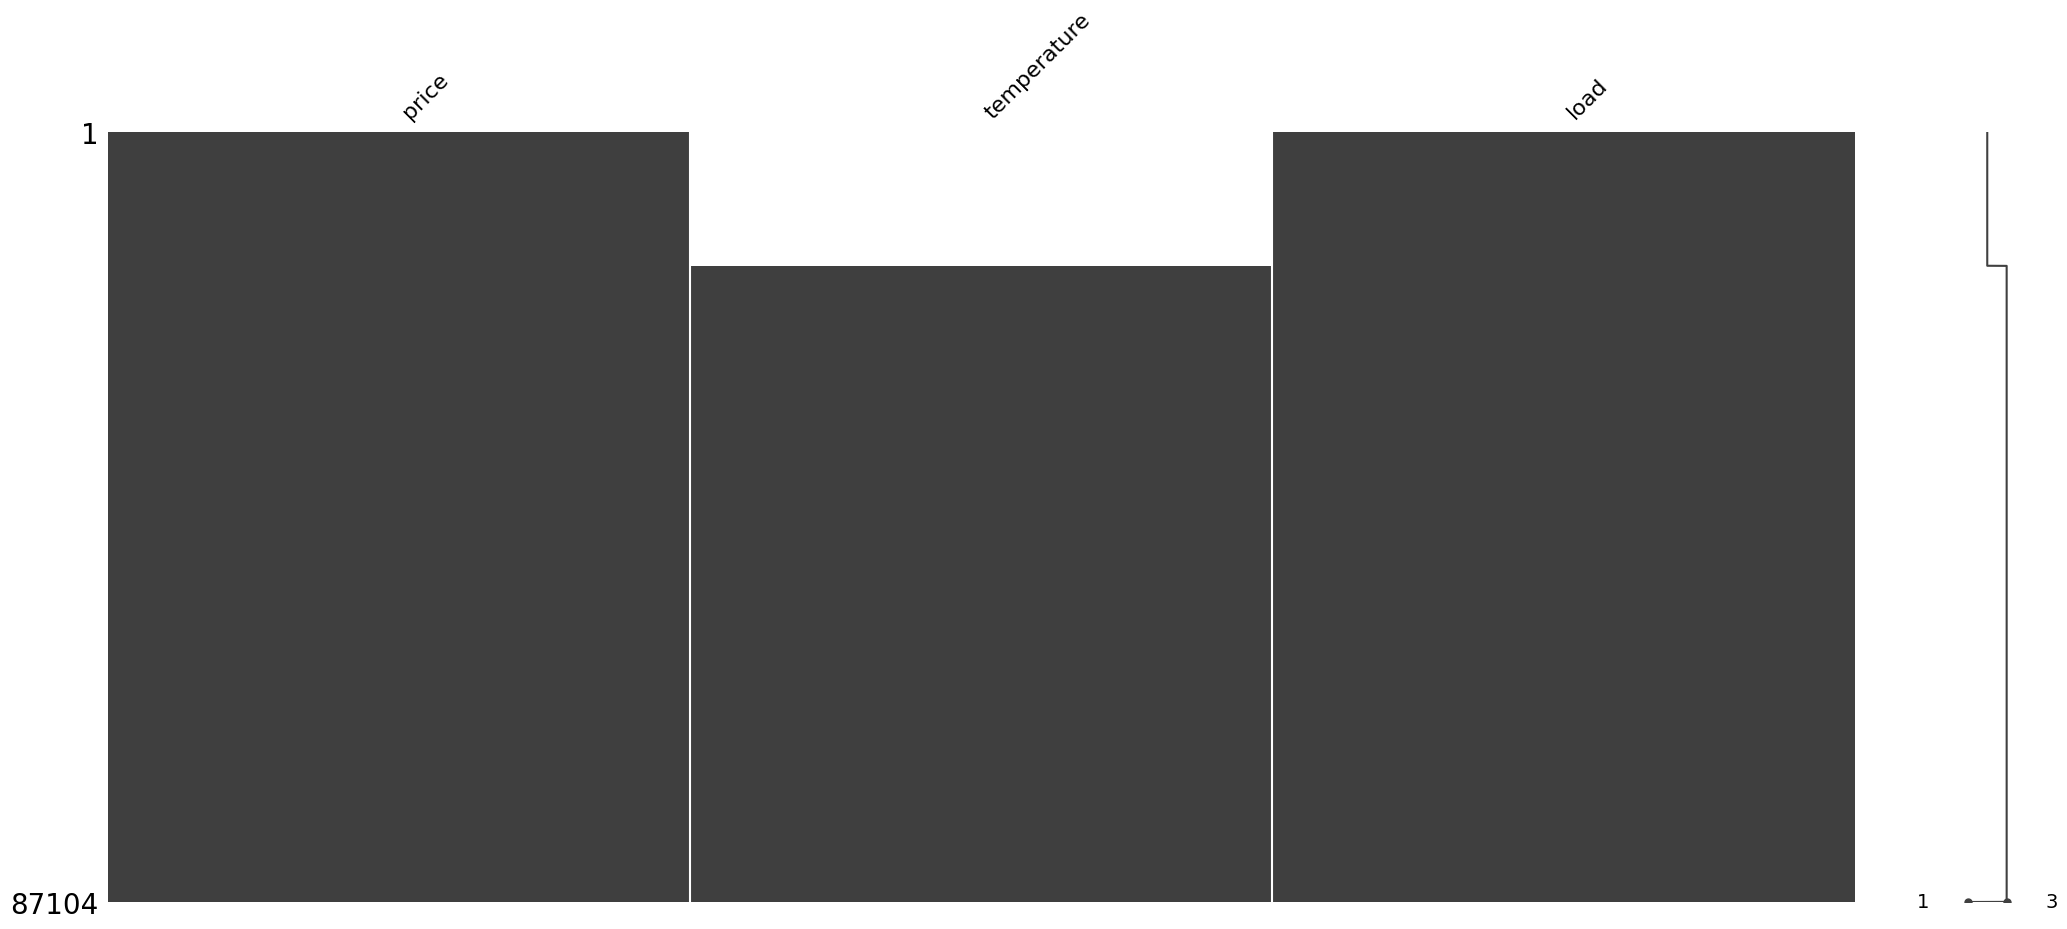

In [187]:
msno.matrix(data_processor.data)

In [188]:
data_processor.dropna()

In [189]:
# Yields 600 obs on test data if split to 24H time buckets, it is fine to conlude on the predictive ability
train, test = data_processor.data[:int(len(data_processor.data)*0.8)], data_processor.data[int(len(data_processor.data)*0.8):]

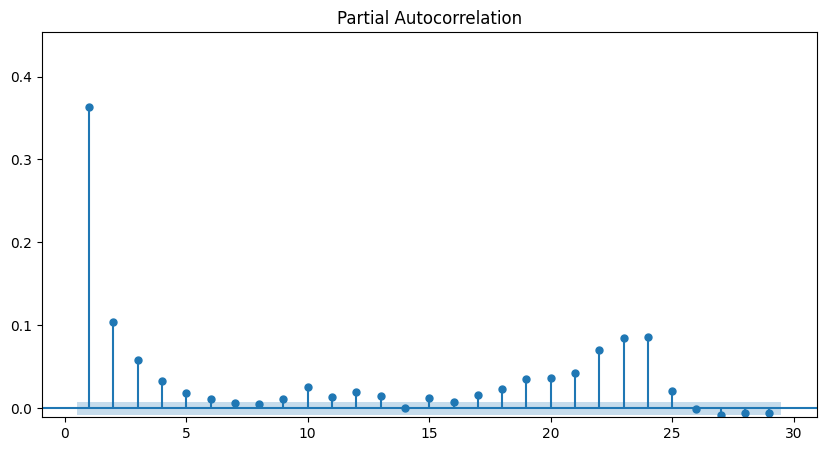

In [190]:
plot_pacf(train['price'], lags=np.arange(1, 30), auto_ylims=True)
plt.show()

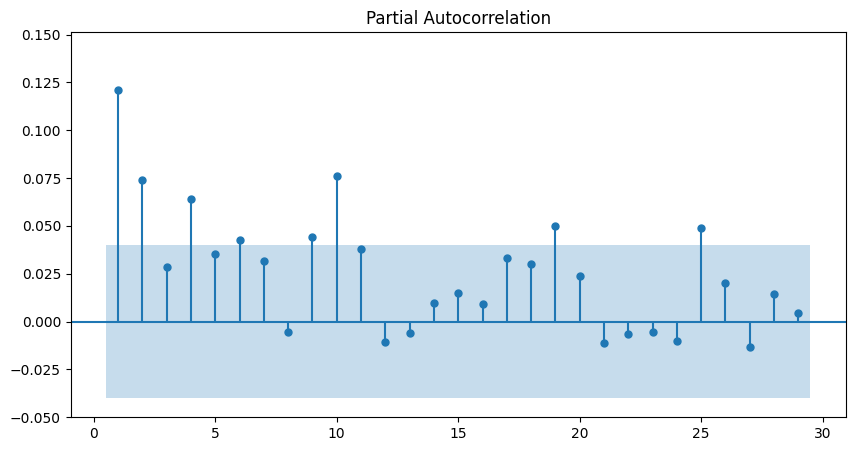

In [191]:
# Plot the pacf for a given hour of a day
HOUR_OF_DAY = 16
plot_pacf(train[train.index.hour==HOUR_OF_DAY]['price'], lags=np.arange(1, 30),
auto_ylims=True, method='ywm')
plt.show()

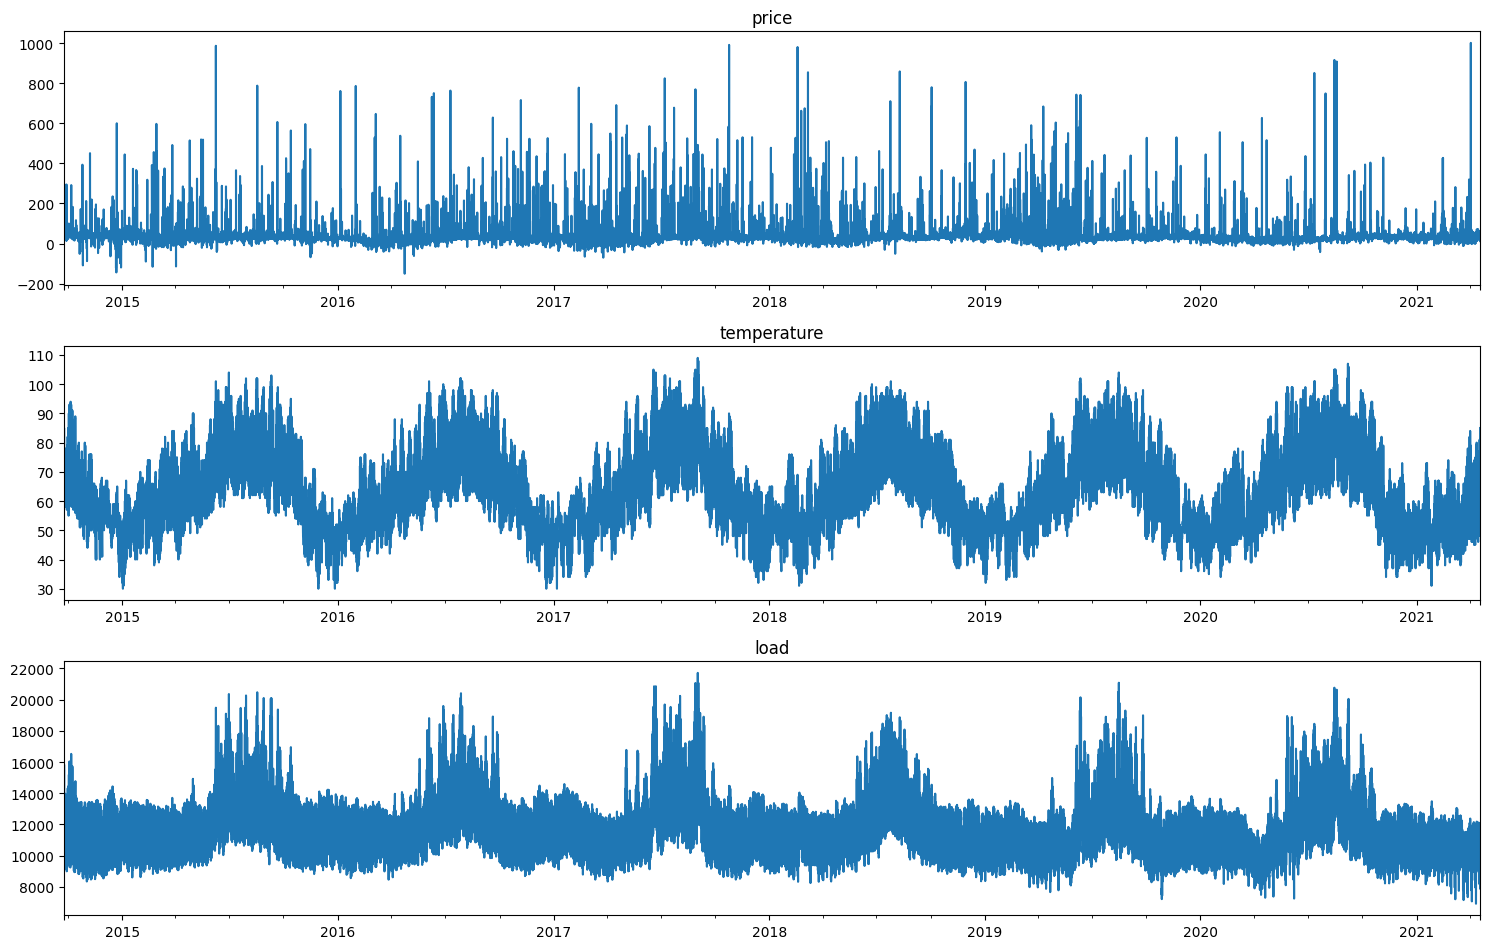

In [192]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10)) # 3 rows, 1 column

train[train.columns[0]].plot(ax=axs[0], title=train.columns[0])
train[train.columns[1]].plot(ax=axs[1], title=train.columns[1])
train[train.columns[2]].plot(ax=axs[2], title=train.columns[2])

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

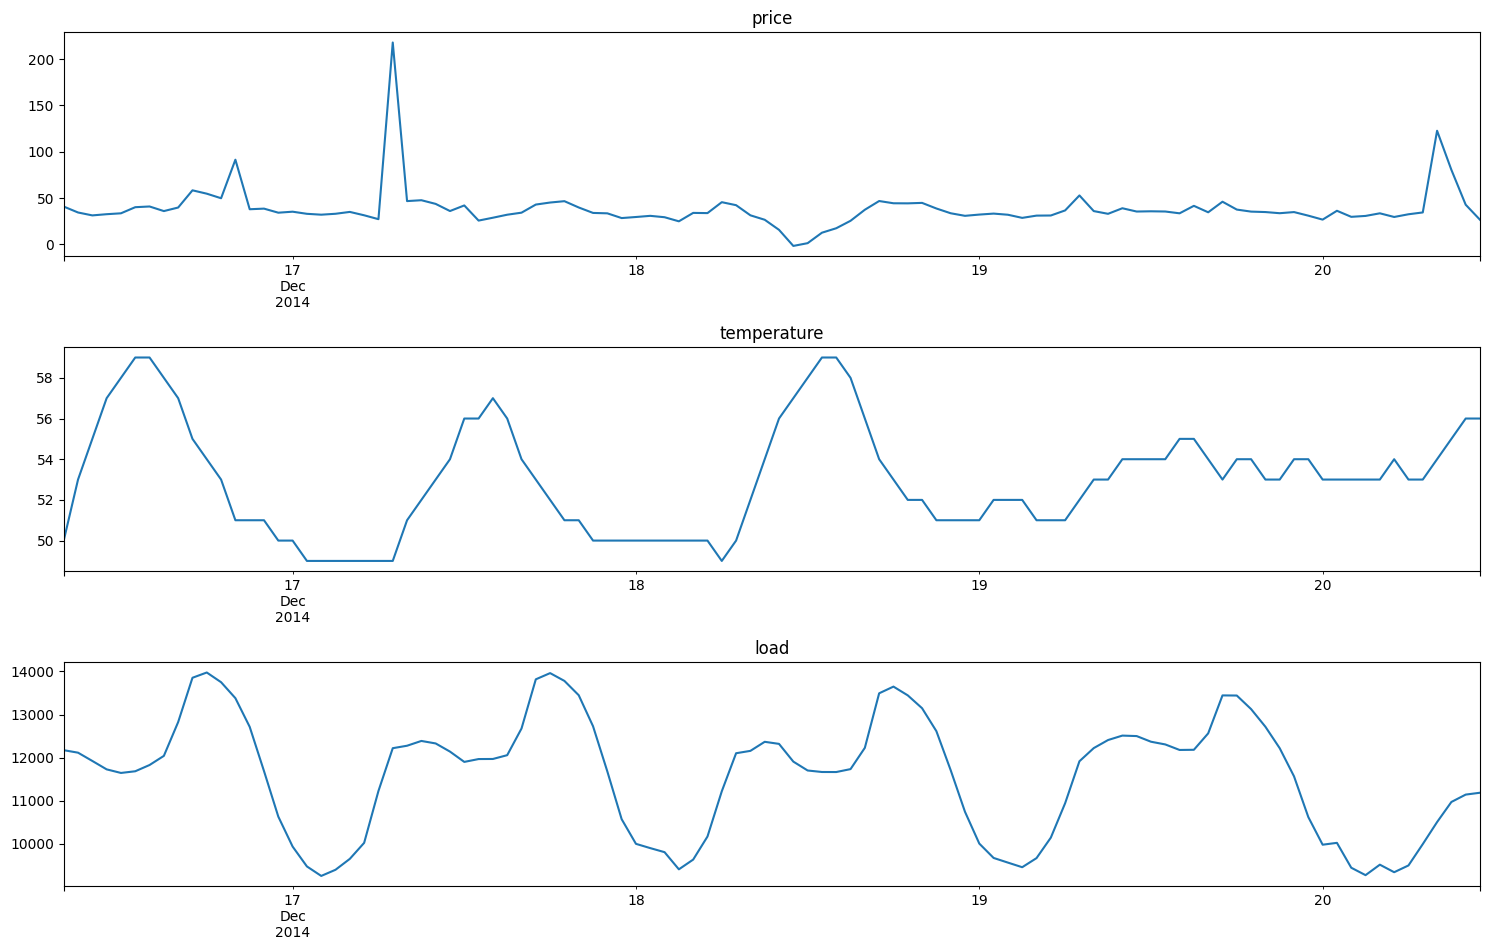

In [193]:
## In more detail
fig, axs = plt.subplots(3, 1, figsize=(15, 10)) # 3 rows, 1 column

train[2000:2100][train.columns[0]].plot(ax=axs[0], title=train.columns[0])
train[2000:2100][train.columns[1]].plot(ax=axs[1], title=train.columns[1])
train[2000:2100][train.columns[2]].plot(ax=axs[2], title=train.columns[2])

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [194]:
# ADF test to examine features stationarity
# Refusing H_0 in favor of the timeseries are stationary (no unit root)
for col in train.columns:
    adf_test = adfuller(train[col], autolag='AIC')
    print(col, adf_test[1])

price 0.0
temperature 1.1549041365700223e-10
load 1.439748063820778e-20


### Feature importance
- Hour-ahead modelling vs. 50-hours ahead and how splitting to hourly (dayhour) is beneficial for the overall model specification.

In [195]:
feature_group1 = ['price', 'temperature', 'load']
feature_group2 = ['price', 'temperature', 'load', 'price_l1', 'price_l2', 'price_l3', 'price_l4', 'price_l5', 'price_l6', 'price_l7', 'price_l8', 'price_l9', 'price_l10', 'price_l11', 'price_l12', 'price_l13', 'price_l14', 'price_l15', 'price_l16', 'price_l17', 'price_l18', 'price_l19', 'price_l20', 'price_l21', 'price_l22', 'price_l23', 'price_l24']
feature_group3 = ['price', 'temperature', 'load', 'seasonal_decomp_temperature_p24', 'seasonal_decomp_temperature_p168', 'seasonal_decomp_temperature_p720', 'seasonal_decomp_temperature_p8640', 'seasonal_decomp_load_p24', 'seasonal_decomp_load_p168', 'seasonal_decomp_load_p720', 'seasonal_decomp_load_p8640']
feature_group4 = ['price', 'temperature', 'load', 'temperature_mean12', 'temperature_mean24', 'roc_temperature_l1', 'load_mean12', 'load_mean24']
feature_group5 = ['price', 'temperature', 'load', 'forecast_load', 'forecast_resid_load', 'roc_load_l1', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'US_holiday']
feature_group6 = ['price', 'temperature', 'load', 'price_pseudo_1', 'temp_pseudo_1', 'load_pseudo_1', 'price_pseudo_2', 'temp_pseudo_2', 'load_pseudo_2', 'price_pseudo_3', 'temp_pseudo_3', 'load_pseudo_3', 'price_pseudo_4', 'temp_pseudo_4', 'load_pseudo_4', 'price_pseudo_5', 'temp_pseudo_5',  'load_pseudo_5', 'price_pseudo_6', 'temp_pseudo_6', 'load_pseudo_6', 'price_pseudo_7', 'temp_pseudo_7', 'load_pseudo_7', 'price_pseudo_8', 'temp_pseudo_8', 'load_pseudo_8', 'price_pseudo_9', 'temp_pseudo_9', 'load_pseudo_9', 'price_pseudo_10', 'temp_pseudo_10', 'load_pseudo_10', 'price_pseudo_11', 'temp_pseudo_11', 'load_pseudo_11', 'price_pseudo_12', 'temp_pseudo_12', 'load_pseudo_12', 'price_pseudo_13', 'temp_pseudo_13', 'load_pseudo_13',       'price_pseudo_14', 'temp_pseudo_14', 'load_pseudo_14',       'price_pseudo_15', 'temp_pseudo_15', 'load_pseudo_15', 'price_pseudo_16', 'temp_pseudo_16', 'load_pseudo_16', 'price_pseudo_17', 'temp_pseudo_17', 'load_pseudo_17', 'price_pseudo_18', 'temp_pseudo_18', 'load_pseudo_18', 'price_pseudo_19', 'temp_pseudo_19', 'load_pseudo_19', 'price_pseudo_20', 'temp_pseudo_20', 'load_pseudo_20', 'price_pseudo_21', 'temp_pseudo_21', 'load_pseudo_21', 'price_pseudo_22', 'temp_pseudo_22', 'load_pseudo_22', 'price_pseudo_23', 'temp_pseudo_23', 'load_pseudo_23']
feature_group7 = ['price', 'temperature', 'load', 'price_plag2', 'price_plag3', 'price_plag4', 'price_plag5', 'price_plag6', 'price_plag7', 'price_plag8', 'price_plag9', 'price_plag10', 'price_plag11', 'price_plag12', 'price_plag13', 'price_plag14', 'price_plag15', 'price_plag16', 'price_plag17', 'price_plag18', 'price_plag19', 'price_plag20', 'price_plag21',  'price_plag22', 'price_plag23', 'price_plag24', 'temperature_plag2', 'temperature_plag3', 'temperature_plag4', 'temperature_plag5', 'temperature_plag6', 'temperature_plag7', 'temperature_plag8', 'temperature_plag9', 'temperature_plag10', 'temperature_plag11', 'temperature_plag12', 'temperature_plag13', 'temperature_plag14', 'temperature_plag15', 'temperature_plag16', 'temperature_plag17', 'temperature_plag18', 'temperature_plag19', 'temperature_plag20', 'temperature_plag21', 'temperature_plag22', 'temperature_plag23', 'temperature_plag24', 'load_plag2', 'load_plag3', 'load_plag4', 'load_plag5', 'load_plag6', 'load_plag7', 'load_plag8', 'load_plag9', 'load_plag10', 'load_plag11', 'load_plag12', 'load_plag13', 'load_plag14', 'load_plag15', 'load_plag16', 'load_plag17', 'load_plag18', 'load_plag19', 'load_plag20', 'load_plag21', 'load_plag22', 'load_plag23', 'load_plag24']


In [196]:
all_in_one_df = all_data_in_one_sample()
train, test = train_test_split(all_in_one_df, train_size= 0.8, shuffle=False)
result = ols_estimate(train, train['target'])

In [197]:
result.rsquared

0.18993700514380096

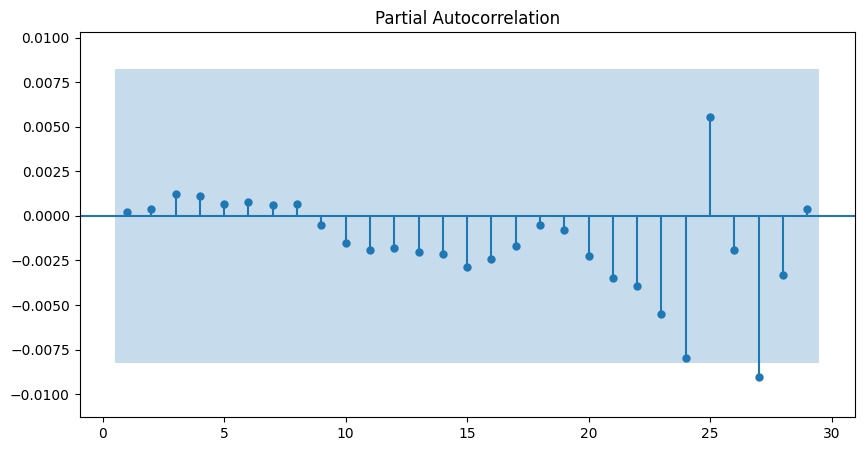

In [198]:
# Autocorrelation in the residuals
plot_pacf(result.resid, lags=np.arange(1, 30), auto_ylims=True)
plt.show()

In [199]:
# Strong heteroskedasticity in the residuals. Would make sense to use GARCH
# However for prediction task, lets just add past return volatilities as exp
# To try to partially capture the heteroskedaticity, by the volatility clust
bp_test = het_breuschpagan(result.resid, result.model.exog)
print(bp_test[1])

0.0


(-50.0, 50.0)

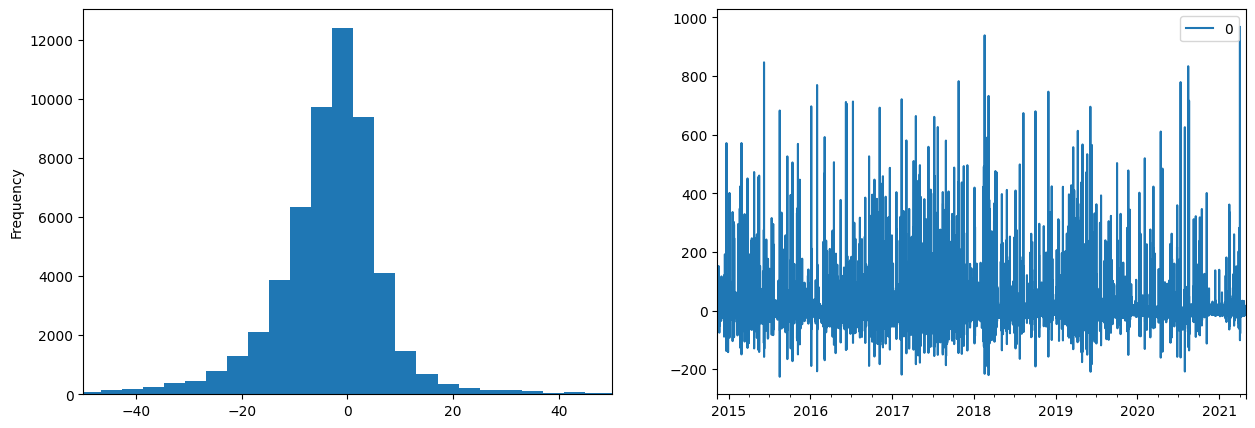

In [200]:
# Plotting the residuals
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
result.resid.plot(kind='hist', bins=300, ax=axes[0])
pd.DataFrame(result.resid).plot(ax=axes[1])
axes[0].set_xlim(-50, 50)

In [201]:
subselect_df = train[train.index.hour==12].copy()
result = ols_estimate(subselect_df, subselect_df['target'])

In [202]:
result.rsquared

0.28919299267186016

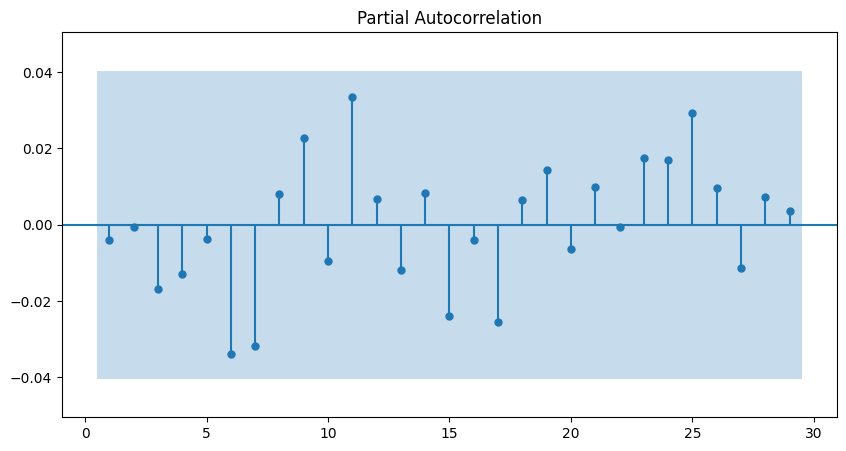

In [203]:
plot_pacf(result.resid, lags=np.arange(1, 30), auto_ylims=True)
plt.show()

In [204]:
# Strong heteroskedasticity in the residuals. Would make sense to use GARCH
# However for prediction task, lets just add past return volatilities as exp
# To try to partially capture the heteroskedaticity, by the volatility clust
bp_test = het_breuschpagan(result.resid, result.model.exog)
print(bp_test[1])

3.07728450136164e-35


(-50.0, 50.0)

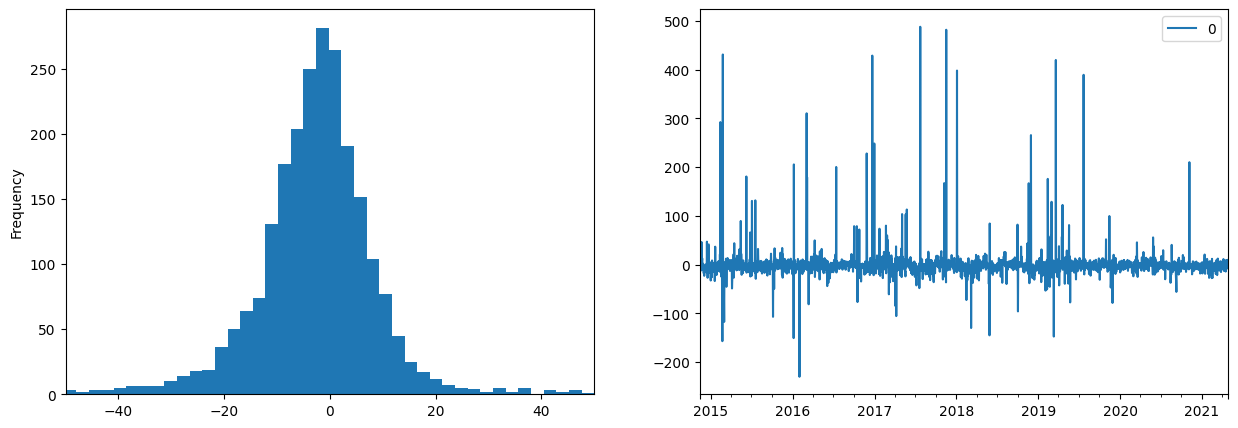

In [205]:
# Plotting the residuals
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
result.resid.plot(kind='hist', bins=300, ax=axes[0])
pd.DataFrame(result.resid).plot(ax=axes[1])
axes[0].set_xlim(-50, 50)

### Turn the attention to 50 hours ahead

In [206]:
all_in_one_df = all_data_in_one_sample(target_shift=-50)
train, test = train_test_split(all_in_one_df, train_size= 0.8, shuffle=False)
result = ols_estimate(train, train['target'])

In [207]:
result.rsquared

0.05864046283783597

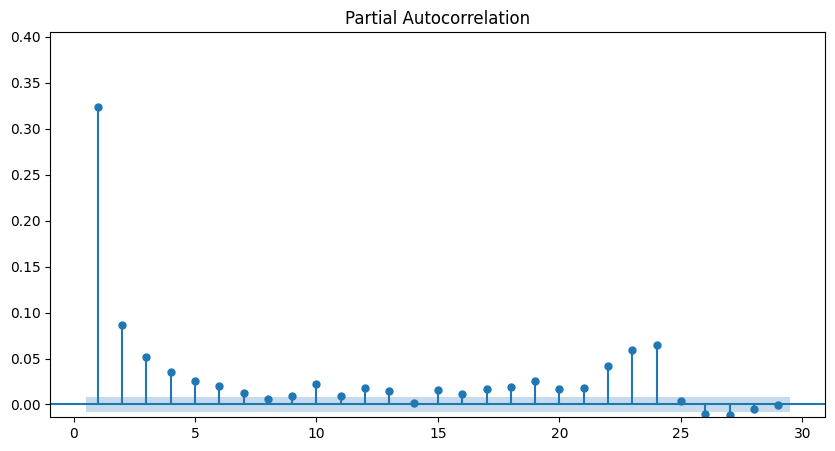

In [208]:
plot_pacf(result.resid, lags=np.arange(1, 30), auto_ylims=True)
plt.show()

In [ ]:
data_processor = DataProcessor.from_csv()
X, y = data_processor.dayhour_data(50, 12)
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size= 0.8, shuffle=False)
result = ols_estimate(train_X, train_y)

In [212]:
result.rsquared

0.18871160687055122

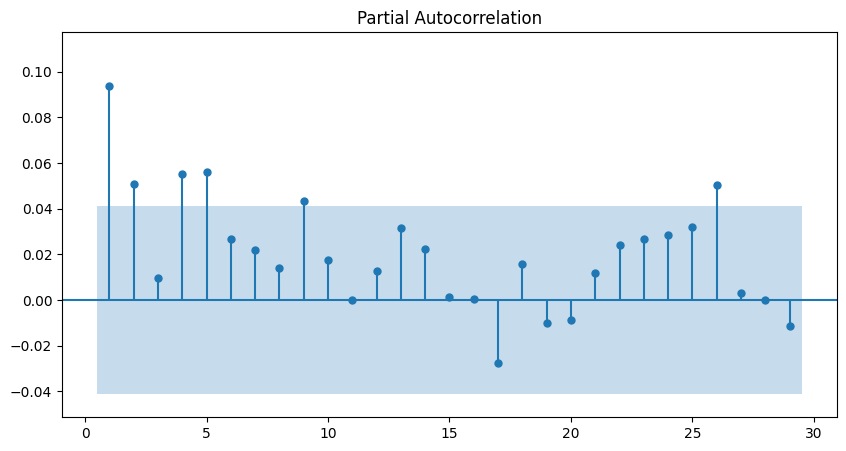

In [213]:
plot_pacf(result.resid, lags=np.arange(1, 30), auto_ylims=True)
plt.show()

### Smoothing explanatory variables
 - Experimented with winsorisation, box-cox and log transformation.
 - Somehow improved the in-sample MAE results.

In [214]:
to_winsor = 'price'
winsored_features = []
non_winsored_features = []
for col in train.columns:
    if to_winsor in col:
        #train[f'wins_{col}'] = power_transform(
        #    np.array(data_processor.data[col]).reshape(-1, 1), 
        #    method='yeo-johnson')
        train[f'wins_{col}'] = winsorize(train[col], limits=[0.1, 0.1])
        winsored_features.append(f'wins_{col}')
        non_winsored_features.append(col)

In [215]:
subselect_df = train[train.index.hour==13].copy()
y_train = subselect_df['target']
X_train = subselect_df[winsored_features]
result = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [216]:
mean_squared_error(y_train, result.predict(sm.add_constant(X_train)))

2397.5578414151505

In [217]:
mean_absolute_error(y_train, result.predict(sm.add_constant(X_train)))

19.114014617620946

In [218]:
subselect_df = train[train.index.hour==13].copy()
y_train = winsorize(np.log(subselect_df['target']+100), limits=[0.05, 0.05])
X_train = subselect_df[winsored_features]
result = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [219]:
# For log transform evaluation, this is not the correct way to transfom back a target variable!!!
mean_squared_error(subselect_df['target'], (np.exp(result.predict(sm.add_constant(X_train)))-100))

2474.2518027534056

In [220]:
mean_absolute_error(subselect_df['target'], (np.exp(result.predict(sm.add_constant(X_train)))-100))

16.87424765885795

# Ability to learn
 - First, I investigate whether a more complex algorithm is able to learn from the features we have.
 - Secondly, I demonstrate the necessity of splitting the data sample by hour of the day.
     - Under this condition, the algorithm can still learn in 50 days.
     - If it is all in one data set, there is nothing to learn. 

In [221]:
data = all_data_in_one_sample(target_shift=-50)
# Use all features
features = [col for col in train.columns if col!='target']
# Use only feature_groupX
features = feature_group3
target = 'target'

In [176]:
# Split for dayhour
subselect_train = data[data.index.hour==12].copy()
data_X, _ = train_test_split(subselect_train, train_size= 0.8, shuffle=False)

In [179]:
# Split for whole dataset
data_X, _ = train_test_split(data, train_size=0.8, shuffle=False)

In [181]:
%%capture
N_SPLITS = 5
train_X = data_X[features]
train_y = data_X['target']

tscv = TimeSeriesSplit(n_splits=N_SPLITS, test_size=int((len(train_X)-500)/N_SPLITS), max_train_size=2500)
metric = 'l1'
#metric = 'mape'
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    early_stopping_rounds=100,
    num_leaves=5,
    learning_rate=0.1,
)

results_training = {}
for i, (train_idx, val_idx) in enumerate(tscv.split(train_X)):
    lgb_train_X, lgb_val_X, lgb_train_y, lgb_val_y = \
        train_X.iloc[train_idx], train_X.iloc[val_idx], \
        train_y.iloc[train_idx], train_y.iloc[val_idx]
    model.fit(lgb_train_X, lgb_train_y,
        eval_set=[(lgb_train_X, lgb_train_y), (lgb_val_X, lgb_val_y)],
        eval_metric=metric)
    results_training[i] = pd.DataFrame({
        'training': model.evals_result_['training'][metric],
        'validation': model.evals_result_['valid_1'][metric],
        'run': [i]*len(model.evals_result_['training'][metric])
    })

In [ ]:
# Plot learning curves
results_training = pd.concat(results_training.values(), axis=0)
for run in results_training['run'].unique():
    # Erase this if you want to plot all learning curves across all folds
    #if run != 3:
    #    continue
    tmp = results_training[results_training['run']==run]
    plt.figure(figsize=(10, 5))
    plt.plot(tmp['training'], label='train l1')
    plt.plot(tmp['validation'], label='valid l1')
    plt.legend()
    plt.show()

## Case of all in one sample and 50 hours ahead

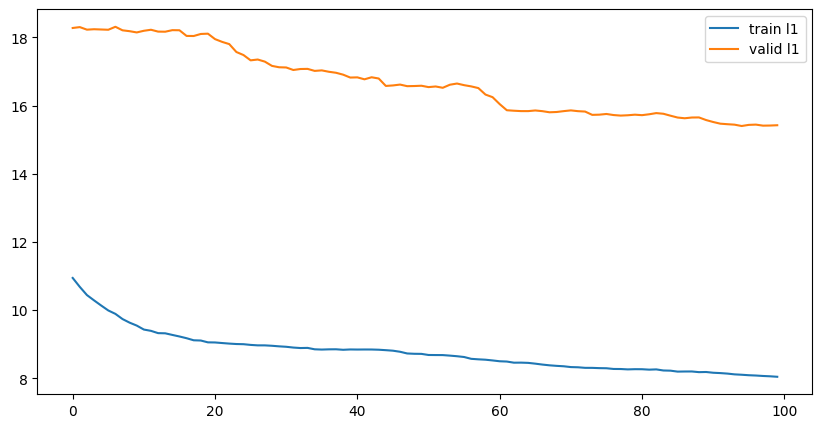

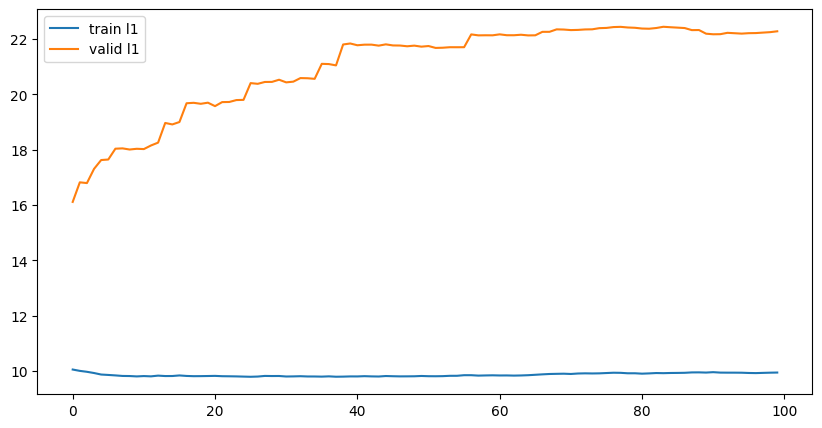

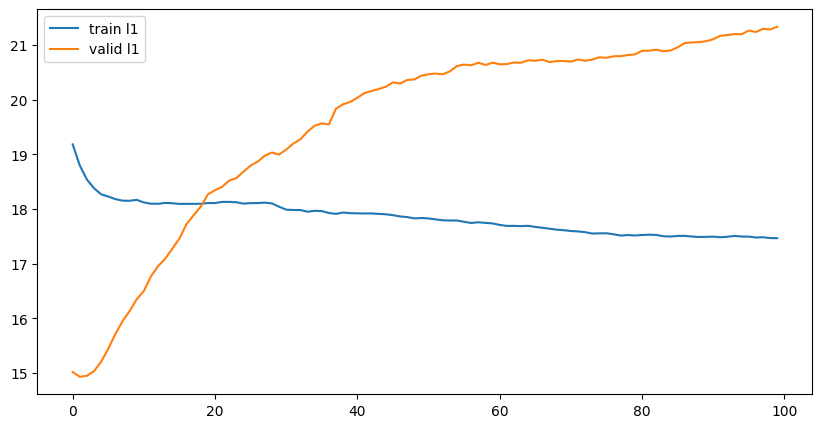

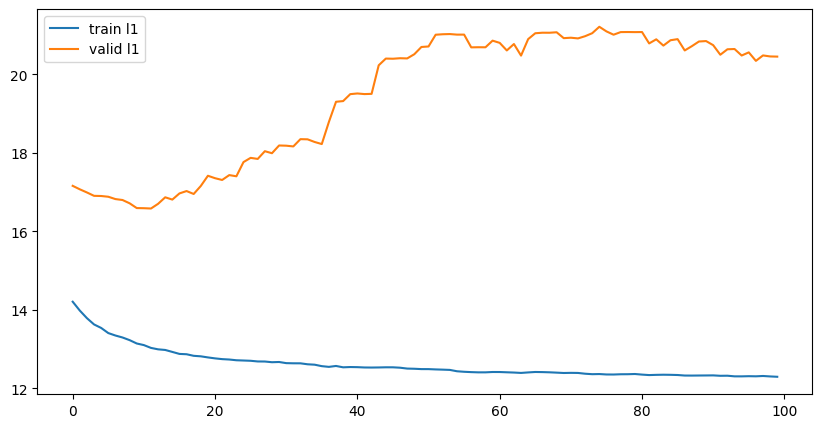

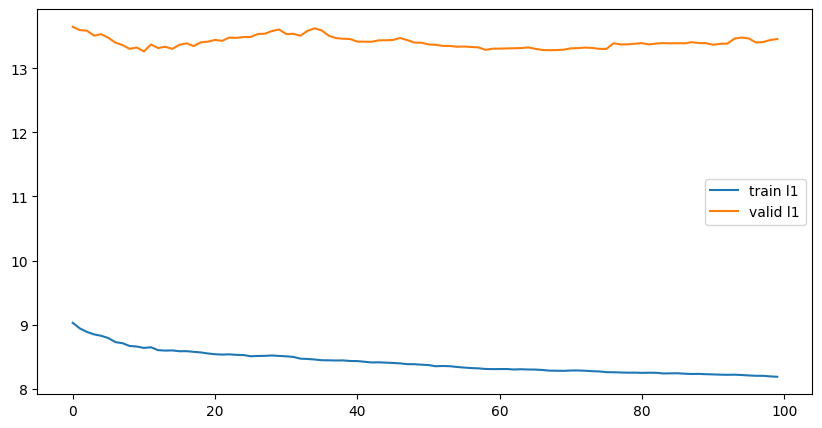

## Case of dayhour==12 and 50 hours ahead

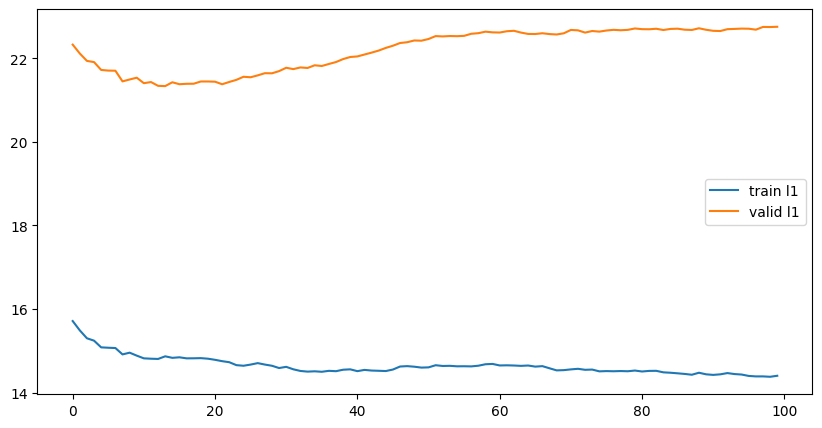

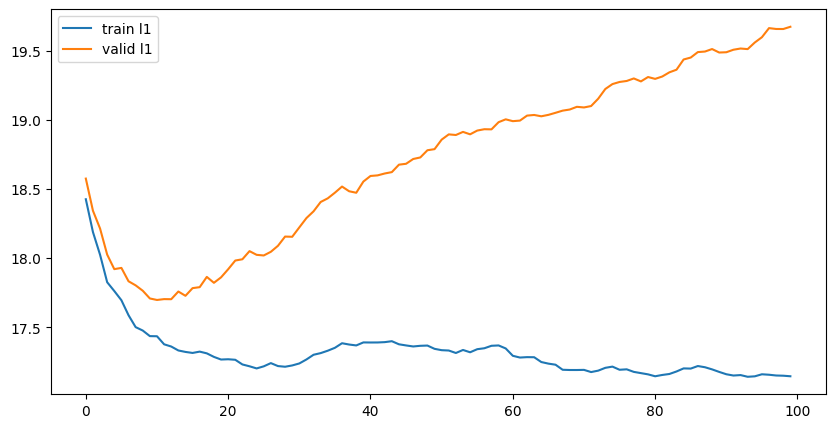

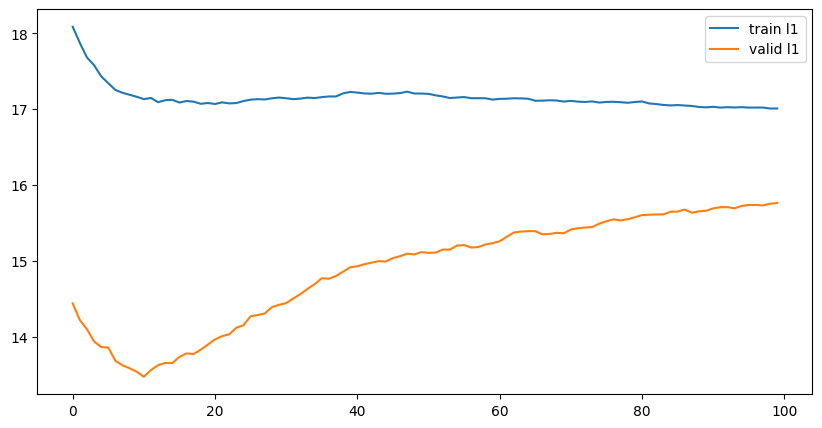

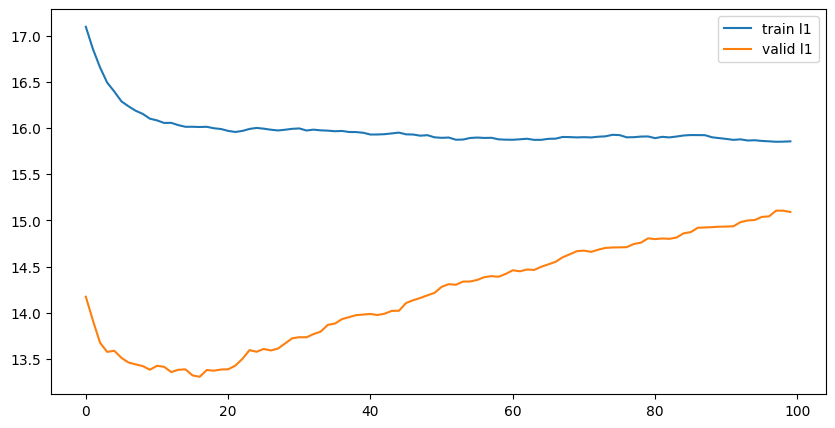

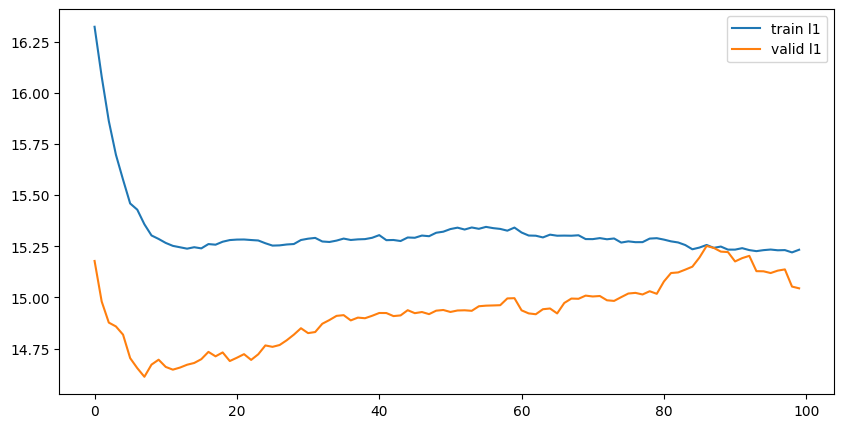

## Learning in case of 1-hour ahead in both cases, dayhour data and all in one sample

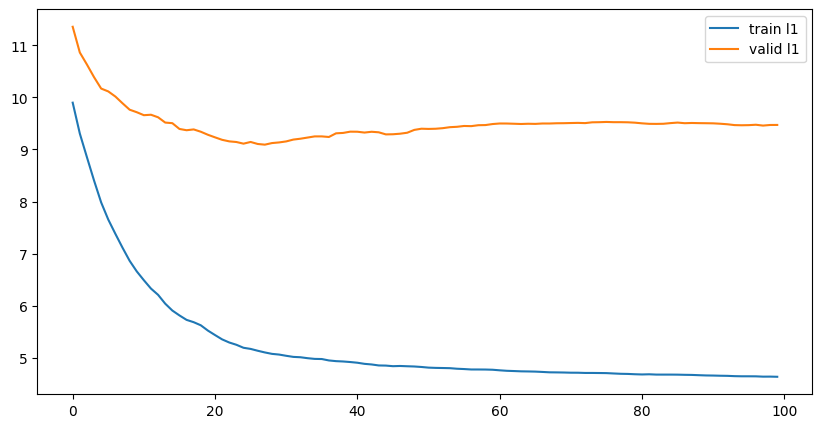

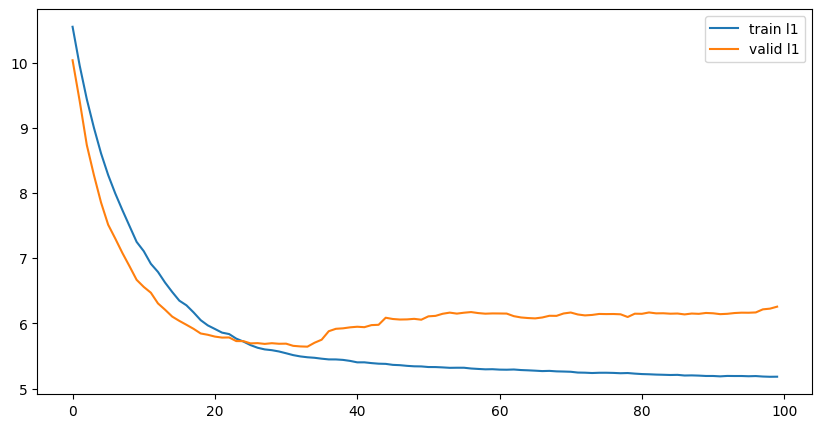

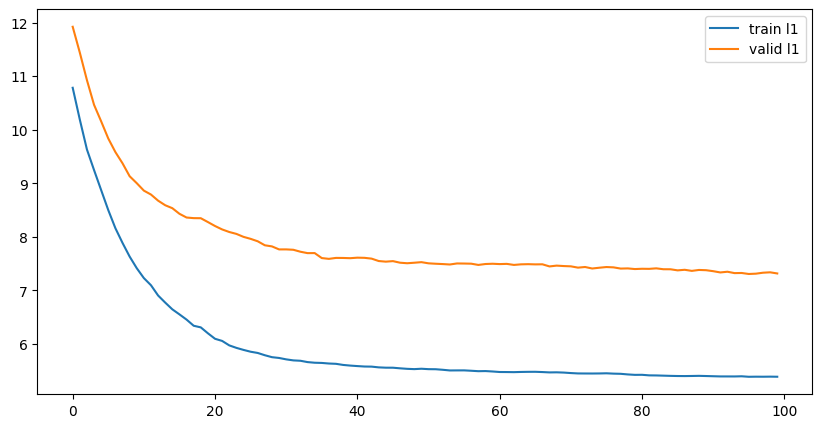

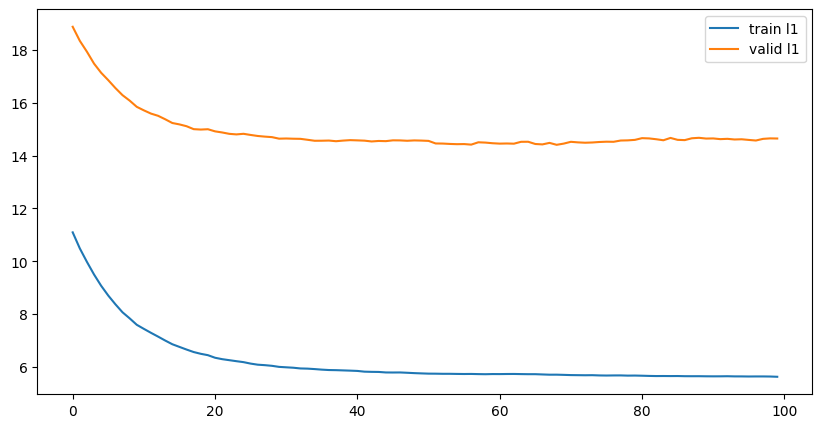

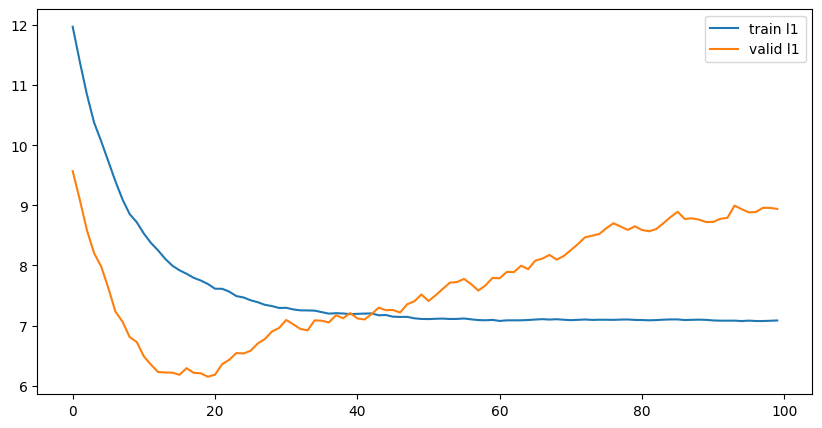

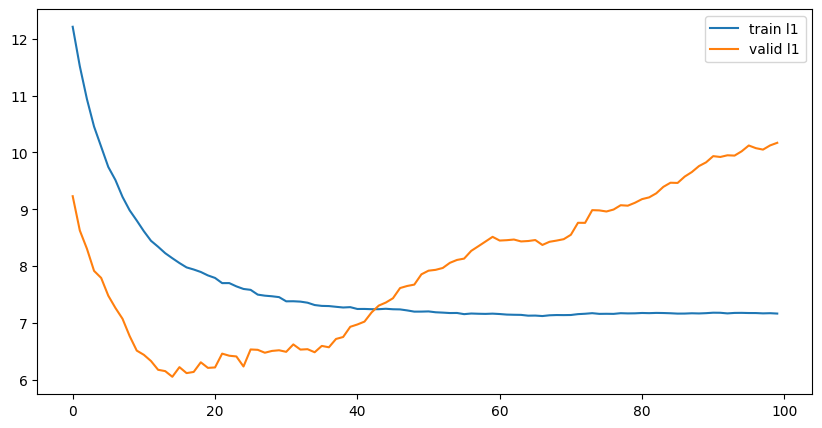

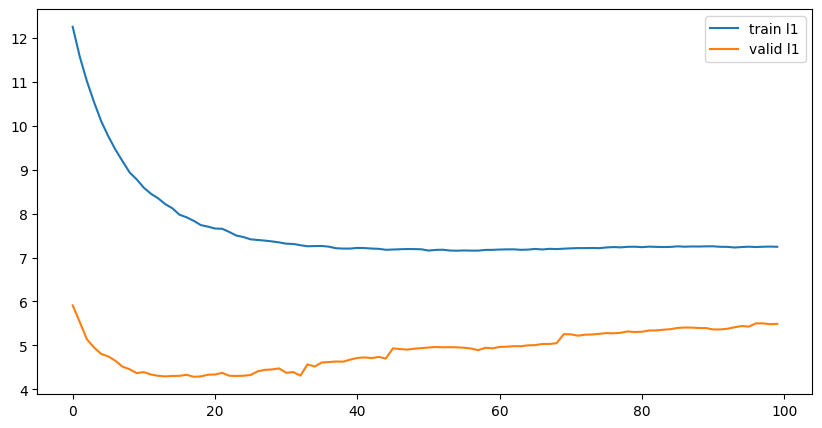

# Training and evaluation
 - This task is carried out in the enclosed code and the instructions to run it are at github url: